<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
#modeling

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

📌 1.1 데이터 EDA 및 시각화

In [106]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,F,18.0,A,4,4,mother,2,2.0,0,4,3.0,6
1,F,17.0,T,1,1,father,2,1.0,0,5,3.0,4
2,F,15.0,T,1,1,mother,2,1.0,3,4,3.0,10
3,F,15.0,T,2,4,mother,3,1.0,0,3,2.0,2
4,F,NaN,T,3,3,father,2,1.0,0,4,3.0,4


In [107]:
# 1) 결측
display(df.isna().sum().to_frame().T)

# 2) 분포 & 분포 시각화 - 12개 컬럼
display(df.describe())



,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,0,3,0,0,0,0,0,3,0,0,5,0


,age,Fedu,Medu,studytime,traveltime,failures,famrel,freetime,absences
count,392.000000,395.000000,395.000000,395.000000,392.000000,395.000000,395.000000,390.000000,395.000000
mean,16.698980,2.521519,2.749367,2.035443,1.446429,0.334177,3.944304,3.233333,5.708861
std,1.279865,1.088201,1.094735,0.839240,0.695022,0.743651,0.896659,1.000985,8.003096
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,0.000000
50%,17.000000,2.000000,3.000000,2.000000,1.000000,0.000000,4.000000,3.000000,4.000000
75%,18.000000,3.000000,4.000000,2.000000,2.000000,0.000000,5.000000,4.000000,8.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,75.000000


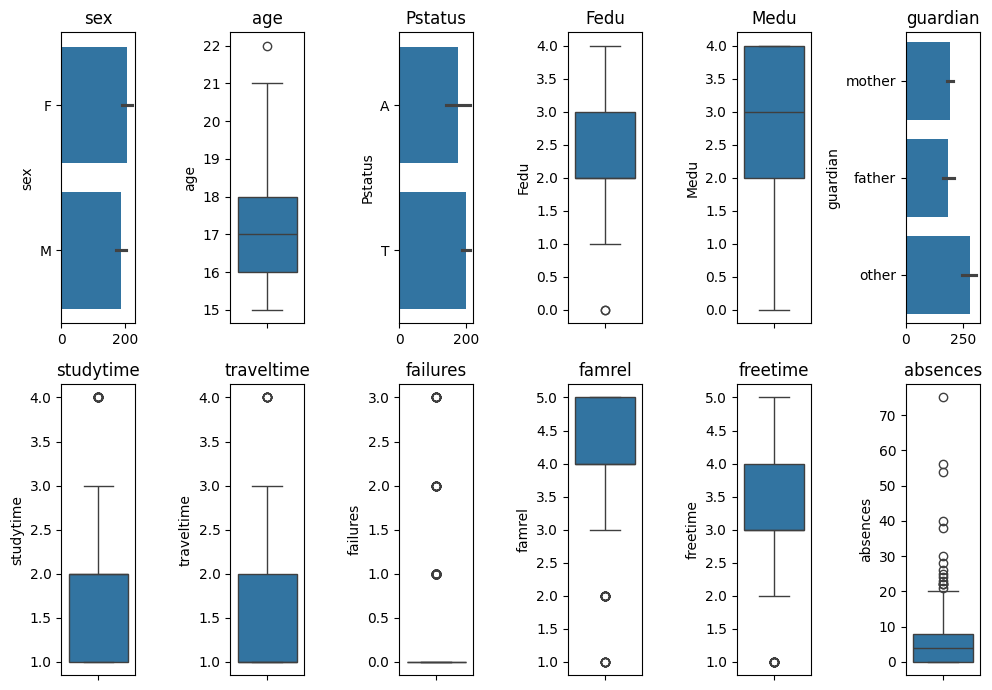

In [108]:
# 데이터 분포 시각화
num_cols = df.select_dtypes(exclude = 'object').columns.tolist()
cate_cols = df.select_dtypes(include = 'object').columns.tolist()

fig, axes = plt.subplots(2,6 , figsize = (10, 7))

for i, axes in enumerate(axes.flat[:len(df.columns)]) :
  col_i = df.columns[i]
  if col_i in num_cols :
    sns.boxplot(df[col_i], ax = axes)
    axes.set_title(col_i)
  elif col_i in cate_cols :
    sns.barplot(df[col_i], ax = axes)
    axes.set_title(col_i)

plt.tight_layout()
plt.show()

<Axes: >

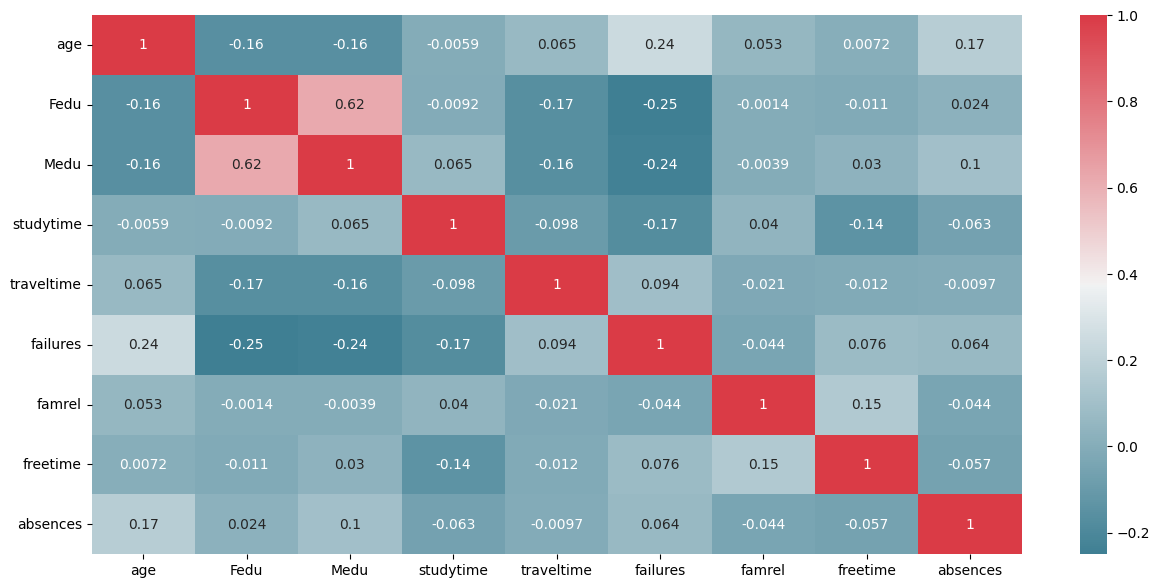

In [109]:
# 상관분석- 다중 공선성 검토
cor_mat = df[num_cols].corr(method = 'pearson')

f, ax = plt.subplots(figsize = (15, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(cor_mat, cmap = cmap, annot = True)

In [110]:
# 통계량 구하기

cols = df.columns.difference(['absences']).tolist()
y = 'absences'


stat_result = []
for col in cols :
  groups = df.groupby(col)[y]
  n_groups = df[col].nunique()

  if n_groups == 2 :
    key = df[col].unique()
    group1 = df[df[col] == key[0]][y]
    group2 = df[df[col] == key[1]][y]
    stat, p_val = stats.ttest_ind(group1, group2, equal_var = False)

  elif n_groups > 2 :
    group_data = [group[1].values for group in groups]
    f_stat, p_val = stats.f_oneway(* group_data)

  stat_result.append([col, round(p_val,4)])

# p < a 기각 0.5이하일떄 유의하다고 판단
stat_df = pd.DataFrame(stat_result, columns = ['variable','p_val'])
stat_df['check'] = stat_df['p_val'].apply(lambda x : '유의' if x < 0.5 else '유의하지않다')
stat_df

,variable,p_val,check
0,Fedu,0.8284,유의하지않다
1,Medu,0.0200,유의
2,Pstatus,0.0868,유의
3,age,0.0099,유의
4,failures,0.0040,유의
5,famrel,0.8410,유의하지않다
6,freetime,0.0381,유의
7,guardian,0.0031,유의
8,sex,0.1743,유의
9,studytime,0.3319,유의


📌 1.2 결측치 처리 및 변화 시각화, 추가 전처리가 필요하다면 이유와 기대효과를 설명

In [111]:
# 결측치
# 1) Age
df['age'] = df['age'].fillna(df['age'].mean())
# 2) traveltime
df['traveltime'].fillna(df['traveltime'].mode()[0], inplace = True)

# 3) freetime
df['freetime'].fillna(df['freetime'].mode()[0], inplace = True)

# 추가 전처리 - dummies
df2 = pd.get_dummies(df, dtype = 'int')

📌 1.3 결석일수 예측모델을 2개 제시하고 선택한 근거 설명

In [112]:
print("""
결석일수는 연속형 변수로 회귀모델과 랜덤 포레스트 선형 회귀 모델을 선택한다.
1) 선형 회귀
  - 변수간 선형관계를 가정하고 예측 할수 있으며, 해석이 용이하여, 독립변수가 종속변수에 미치는 영향을 해석 할 수 있다.
  - 모델이 단순하여, 빠른 피드백과 인사이트를 얻을 수 있다

2) 랜덤포레스트
  - 비선형 관계에서도 강하며, 다수의 결정 트리의 결합으로 복잡한 비선형 관계와 변수가 중요도 파악이 가능하다.
  - 이상치, 노이즈에 강한 성능을 가지며, 앙상블 기법으로 과적합을 방지 할 수 있다.
""")


결석일수는 연속형 변수로 회귀모델과 랜덤 포레스트 선형 회귀 모델을 선택한다. 
1) 선형 회귀 
  - 변수간 선형관계를 가정하고 예측 할수 있으며, 해석이 용이하여, 독립변수가 종속변수에 미치는 영향을 해석 할 수 있다. 
  - 모델이 단순하여, 빠른 피드백과 인사이트를 얻을 수 있다

2) 랜덤포레스트
  - 비선형 관계에서도 강하며, 다수의 결정 트리의 결합으로 복잡한 비선형 관계와 변수가 중요도 파악이 가능하다. 
  - 이상치, 노이즈에 강한 성능을 가지며, 앙상블 기법으로 과적합을 방지 할 수 있다.



📌  1.4 선정한 모델 2가지 생성 및 모델의 평가 기준을 선정하고 선정 이유 설명

In [123]:
# df2

# 선형회귀 모델은 변수간 차이가 큰 경우 회귀 계수 추정이 어려울 수 있음으로, 표준화를 진행한 데이터로 진행
X = df2.drop(columns = 'absences', axis =1)
y = df2['absences']

s_X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns)


# 모델
rf = RandomForestRegressor(random_state=2)
lr = LinearRegression()

def eval_model(model, name) :
  # tran_test 분리
  x_train, x_test, y_train, y_test = train_test_split(s_X, y, test_size = 0.3 , random_state = 1234)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  rmse = np.sqrt(mean_squared_error(pred, y_test))
  r2 = r2_score(pred, y_test)

  return rmse, r2

results = []
for models in ([rf, 'Random_Forest'], [lr, 'Linear_Model']) :
  model = models[0]
  name = models[1]
  rmse, r2  = eval_model(model, name)
  results.append([name, rmse, r2])

display(pd.DataFrame(results, columns=['Model', 'MSE', 'R2']))

print("""
R2 score (결정계수) : 종속 변수의 변동성을 얼마나 잘 설명하는지를 나타내는 지표로 1에 가까울 수록 모델이 데이터를 잘 설명하는 것이다.
RMSE  : 실제 - 예측의 차이를 제곱한 평균으로 값이 작을 수록 예측이 실제값에 가까움을 의미한다. 낮을 수록 예측이 실제와 가깝다는 뜻이다.

""")

,Model,MSE,R2
0,Random_Forest,8.656322,-1.812230
1,Linear_Model,6.953936,-6.158961



R2 score (결정계수) : 종속 변수의 변동성을 얼마나 잘 설명하는지를 나타내는 지표로 1에 가까울 수록 모델이 데이터를 잘 설명하는 것이다. 
RMSE  : 실제 - 예측의 차이를 제곱한 평균으로 값이 작을 수록 예측이 실제값에 가까움을 의미한다. 낮을 수록 예측이 실제와 가깝다는 뜻이다. 




-9.213854104679903


<Axes: xlabel='None', ylabel='None'>

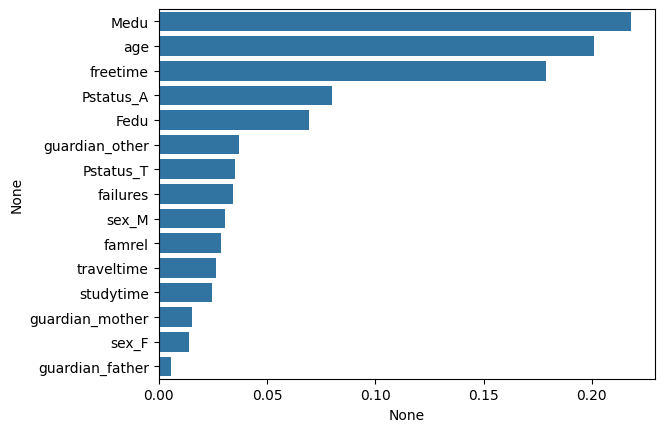

In [133]:
## 파라미터 튜닝
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(s_X, y, test_size = 0.3 , random_state = 1234)

rf = RandomForestRegressor(random_state=2)

params = {
    'max_depth': [2,3,4,5,10] ,
    'min_samples_split': [1, 1.5,2, 2.5] ,
    'min_samples_leaf': [1, 1.5,2, 2.5] }

rf_grid = GridSearchCV(rf, params, scoring = 'neg_mean_squared_error')
rf_grid.fit(x_train, y_train)
rf_pred = rf_grid.predict(x_test)

best_model = rf_grid.best_estimator_

best_pred = best_model.predict(x_test)
r2 = r2_score(best_pred, y_test)
print(r2)

# 변수 중요도
# 변수 중요도
feature_values = best_model.feature_importances_
feature_df = pd.Series(feature_values, index = X.columns).sort_values(ascending = False)
sns.barplot(x = feature_df, y = feature_df.index)

📌 2.1 광고비 변수를 가변수 처리후 다중회귀를 수행하여 회귀계수가 유의한지 검정

In [136]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem2.csv',encoding='cp949')
df.head()

,광고횟수,광고비,매출액
0,2,낮음,15
1,3,낮음,16
2,4,낮음,17
3,4,높음,18
4,5,높음,20


In [143]:
# 광고비 전처리
df['광고비'] = df['광고비'].apply(lambda x : 1 if x == '높음' else 0)

# OLS
y = df['매출액']
x = df.drop(columns = ['매출액'], axis =1)

X = sm.add_constant(x)
model = sm.OLS(y, x).fit()
display(model.summary().tables[0])
display(model.summary().tables[1])

Dep. Variable:,매출액,R-squared (uncentered):,0.937
Model:,OLS,Adj. R-squared (uncentered):,0.931
Method:,Least Squares,F-statistic:,149.2
Date:,"Sun, 16 Mar 2025",Prob (F-statistic):,2.47e-07
Time:,12:24:47,Log-Likelihood:,-34.875
No. Observations:,11,AIC:,71.75
Df Residuals:,10,BIC:,72.15
Df Model:,1,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
광고횟수,2.8522,0.234,12.214,0.000,2.332,3.373
광고비,0,0,nan,nan,0,0


 📌 2.2   A생산라인의 12개 제품 평균은 5.7mm이고 표준편차는 0.03, B생산라인의 12개 제품 평균은 5.6mm이고 표준편차는 0.04이다. 5%유의수준으로 두 제품의 평균이 차이가 있는지 여부를 검정하라 Z(0.05) = 1.96

In [156]:
from scipy.stats import t , norm

x1 = 5.7
s1 = 0.03
n1 = 12

x2 = 5.6
s2 = 0.04
n2 = 12

confa = 0.05
df = n1 + n2 - 2

#  귀무가설 : A.B 라인의 제품 평균 차이가 없다.
#  대가설 : A.B 라인의 제품 평균 차이가 있다.

conft = t.ppf(1 - confa/2, df)

# 합동 분산
sp2 = ((n1 -1) * s1 **2  + (n2 - 1) * s2 ** 2) / df
sp = np.sqrt(sp2)

t_stat = (x1 - x2) / (sp * np.sqrt(1/n1 + 1/n2))

p_val = 2 * (1 - t.cdf(abs(t_stat), df))
print(p_val)

5.892973662380285e-07


📌 바이러스 감염 분류표를 보고 베이지안 분류 방법을 사용해 양성으로 예측된 사람이 실제로 양성일 확률

In [148]:
##           양성  |   음성    - 실제
# 양성    370 (TP) |  10 (FP)
# 음성    15  (FN) | 690 (TN)

TP = 370
TN = 690
FP = 10
FN = 15

# 민감도 계산 - TP / (TP + FN)
# 실제 양성 중, 양성으로 예측됨
sensitivity = TP / (TP + FN)

# False Positive Rte
# 실제 음성 중 양성으로 예측됨
FPR = FP / (TN + FP)

disease_rate=0.01

result = sensitivity * 0.01 / ((sensitivity * 0.01) + (FPR * (1- 0.01)))
result

0.4045926735921268

📌 모분산을 모르는 경우 주어진 데이터의 95% 신뢰구간

In [152]:
# Sigma를 모르는 경우 T검정
data = [3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.4, 4.7]

n = len(data)
x = np.mean(data)
s = np.std(data, ddof = 1)
df = n - 1

se = s / np.sqrt(n)

confa = 0.05
conft = t.ppf(1 - confa /2 , df)

ME = se * conft
print(x - ME, x + ME)

print(t.interval(0.95, df, loc = x, scale = se))

3.4777333085715187 4.300044469206259
(3.4777333085715187, 4.300044469206259)


📌 sigma = 0.04인걸 알고 있을때의 95% 신뢰구간

In [154]:
# Sigma를 아는 경우는 Z 검정
sigma = 0.04

se = sigma / np.sqrt(n)

confz = norm.ppf(1 - confa /2 )

ME = se * confz
print(x - ME, x + ME)
print(norm.interval(0.95, loc = x , scale = se))

3.862756035761688 3.9150217420160898
(3.862756035761688, 3.9150217420160898)
